In [1]:
import numpy as np
import pandas as pd
import yfinance as yf
import warnings
import json

warnings.filterwarnings("ignore")
pd.options.display.float_format = '{:.4%}'.format

params = json.loads(open('../params.json', 'r').read())

# Date range
start = "2022-09-19"
end = "2023-11-19"

# Tickers of assets
industry_asset = json.loads(open('../stocks.json', 'r').read())
assets = []
for key, values in industry_asset.items():
    for value in values:
        assets.append(value)

# Downloading data
data = yf.download(assets, start = start, end = end)

data = data.loc[:,('Adj Close', slice(None))]

data.columns = assets


[*********************100%%**********************]  23 of 23 completed


In [2]:
# Calculating returns
Y = data[assets].pct_change().dropna()

display(Y.tail())

,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
Date,,,,,,,,,,,,,,,,,,,,,
2023-11-10,-2.2464%,-0.0573%,1.9440%,2.1889%,1.1981%,1.9020%,0.1878%,-1.7923%,4.5967%,1.2613%,...,0.1770%,-0.3197%,3.8900%,2.2646%,1.0659%,0.6384%,-0.0853%,1.5326%,-0.3730%,1.1917%
2023-11-13,-0.0696%,-5.1605%,-0.7291%,0.4510%,-0.2368%,0.0718%,2.2222%,-1.7621%,0.5793%,-0.9193%,...,-0.7951%,2.2448%,-0.3658%,-0.9883%,0.6661%,-0.6920%,2.2203%,-0.2096%,0.2808%,1.1178%
2023-11-14,1.0104%,2.7811%,1.1299%,0.5612%,8.7025%,2.1521%,3.3787%,3.7156%,2.2443%,1.7360%,...,1.0240%,1.1500%,1.4903%,-2.9575%,2.0007%,-0.2904%,2.3392%,3.0952%,1.7265%,0.4935%
2023-11-16,2.0697%,-0.3529%,2.4302%,1.9531%,6.9141%,1.6854%,3.1416%,-1.2971%,1.1072%,1.2357%,...,1.4985%,-2.0155%,-3.5327%,1.7143%,-0.4122%,-1.6308%,0.6531%,0.6657%,-0.3670%,-0.4714%
2023-11-17,0.3054%,-0.8855%,-0.5181%,-1.8062%,1.1573%,-0.8748%,-0.7369%,1.1264%,0.2690%,-0.4650%,...,0.4776%,4.2194%,2.5369%,-0.8614%,-0.1104%,-1.8354%,-0.1622%,0.1889%,-1.1050%,-0.6118%


,PETR3.SA,GPAR3.SA,TAEE11.SA,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EGIE3.SA,VALE3.SA
0,6.1510%,3.3447%,14.7453%,17.7232%,7.5085%,10.1745%,1.7974%,24.4450%,14.1103%


Total: 99.99998740700906
Symbols: ['PETR3.SA', 'GPAR3.SA', 'TAEE11.SA', 'ALUP11.SA', 'CPFE3.SA', 'CMIG3.SA', 'ELET3.SA', 'EGIE3.SA', 'VALE3.SA']


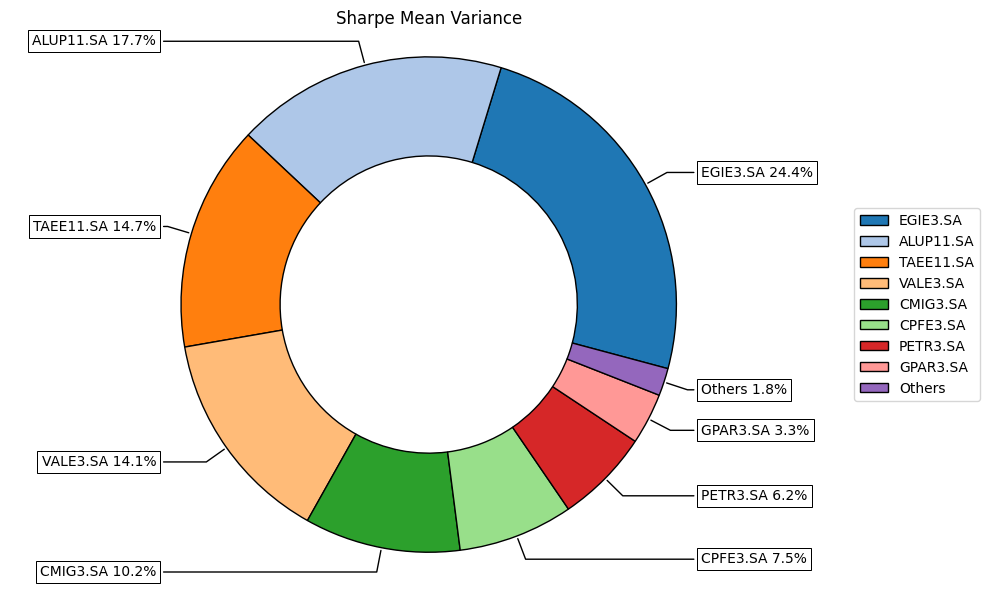

In [3]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'Sharpe' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_sharpe = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

#display(w_sharpe.T)
keys = w_sharpe.T.keys()
filtered_keys= []
w_sharpe_filtered_weights_raw = []
total_w_sharpe_filtered_weights = 0
for key in keys:
    if w_sharpe.T[key]["weights"] > 0.01:
        filtered_keys.append(key)
        w_sharpe_filtered_weights_raw.append(w_sharpe.T[key]["weights"])
        total_w_sharpe_filtered_weights += w_sharpe.T[key]["weights"]

w_sharpe_filtered_weights = pd.DataFrame([w_sharpe_filtered_weights_raw], columns=filtered_keys)
display(w_sharpe_filtered_weights)
print(f"Total: {total_w_sharpe_filtered_weights*100}")
print(f"Symbols: {[key for key in filtered_keys]}")
    
# Plotting the composition of the portfolio

ax_sharpe = rp.plot_pie(w=w_sharpe, title='Sharpe Mean Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

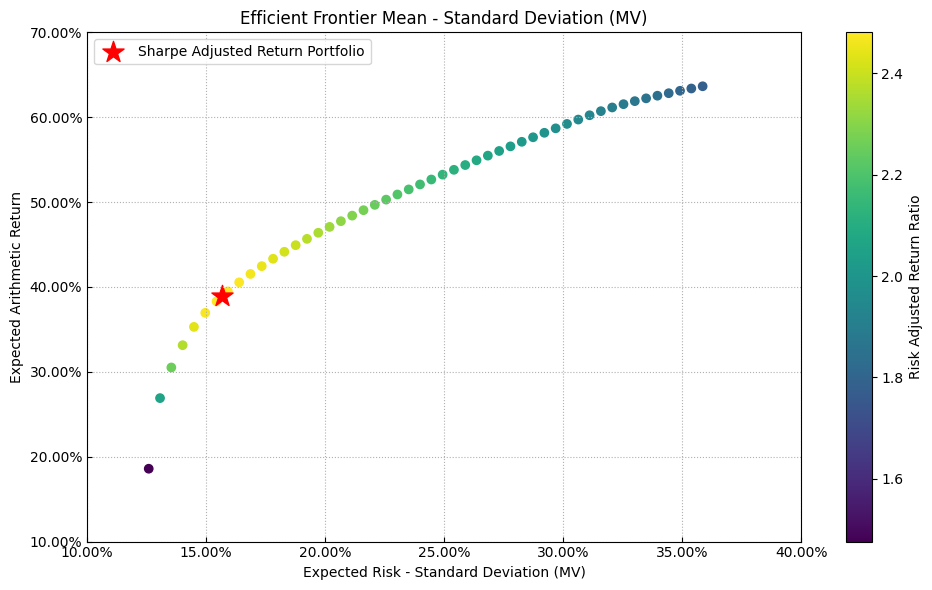

In [4]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Sharpe Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_sharpe, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [5]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [6]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
TIMS3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,2.79%,4.10%,3.96%,5.50%,4.20%
VIVT3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
SUZB3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
KLBN11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CSAN3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.22%,0.16%,0.00%,3.36%,2.93%,2.05%,2.68%,2.18%
VBBR3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PRIO3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
UGPA3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
ENAT3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PETR3.SA,6.15%,0.81%,6.90%,0.00%,7.54%,13.25%,3.67%,3.25%,0.00%,0.00%,0.00%,0.00%,0.00%


,TIMS3.SA,VIVT3.SA,SUZB3.SA,KLBN11.SA,CSAN3.SA,VBBR3.SA,PRIO3.SA,UGPA3.SA,ENAT3.SA,PETR3.SA,...,ALUP11.SA,CPFE3.SA,CMIG3.SA,ELET3.SA,EQTL3.SA,EGIE3.SA,VALE3.SA,GGBR3.SA,CSNA3.SA,FESA4.SA
weights,5.8250%,0.0000%,0.0000%,0.0000%,0.0000%,11.1231%,0.0000%,0.0000%,0.0000%,0.0000%,...,0.4555%,3.3679%,2.1659%,15.3520%,24.1591%,10.9622%,0.0000%,6.9451%,0.0000%,3.8002%


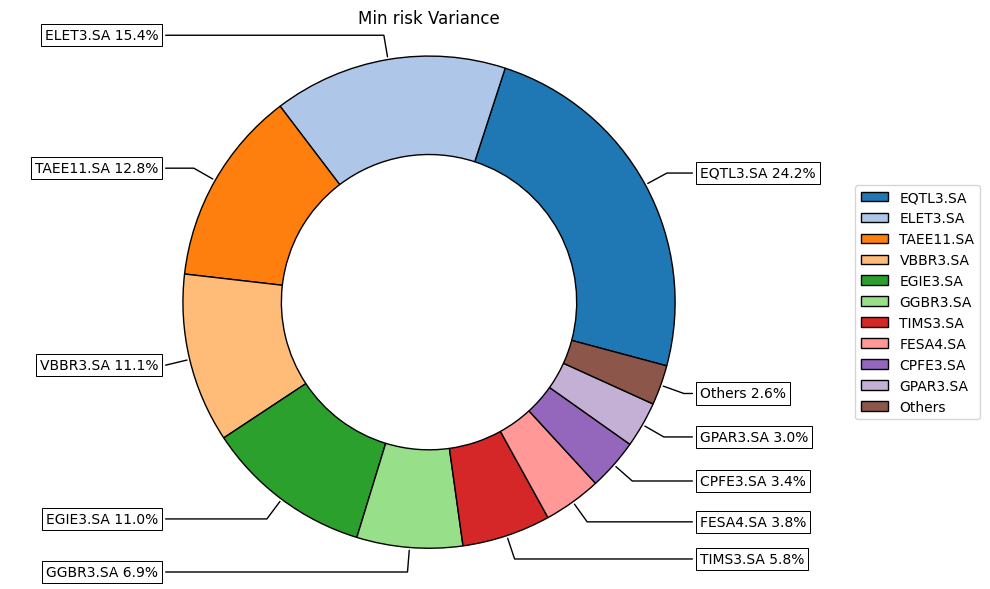

In [7]:
import riskfolio as rp

# Building the portfolio object
port = rp.Portfolio(returns=Y)

# Calculating optimal portfolio

# Select method and estimate input parameters:

method_mu='hist' # Method to estimate expected returns based on historical data.
method_cov='hist' # Method to estimate covariance matrix based on historical data.

port.assets_stats(method_mu=method_mu, method_cov=method_cov, d=0.94)

# Estimate optimal portfolio:

model='Classic' # Could be Classic (historical), BL (Black Litterman) or FM (Factor Model)
rm = 'MV' # Risk measure used, this time will be variance
obj = 'MinRisk' # Objective function, could be MinRisk, MaxRet, Utility or Sharpe
hist = True # Use historical scenarios for risk measures that depend on scenarios
rf = 0 # Risk free rate
l = 0 # Risk aversion factor, only useful when obj is 'Utility'

w_min_risk = port.optimization(model=model, rm=rm, obj=obj, rf=rf, l=l, hist=hist)

display(w_min_risk.T)


# Plotting the composition of the portfolio

ax_min_risk = rp.plot_pie(w=w_min_risk, title='Min risk Variance', others=0.05, nrow=25, cmap = "tab20",
                 height=6, width=10, ax=None)

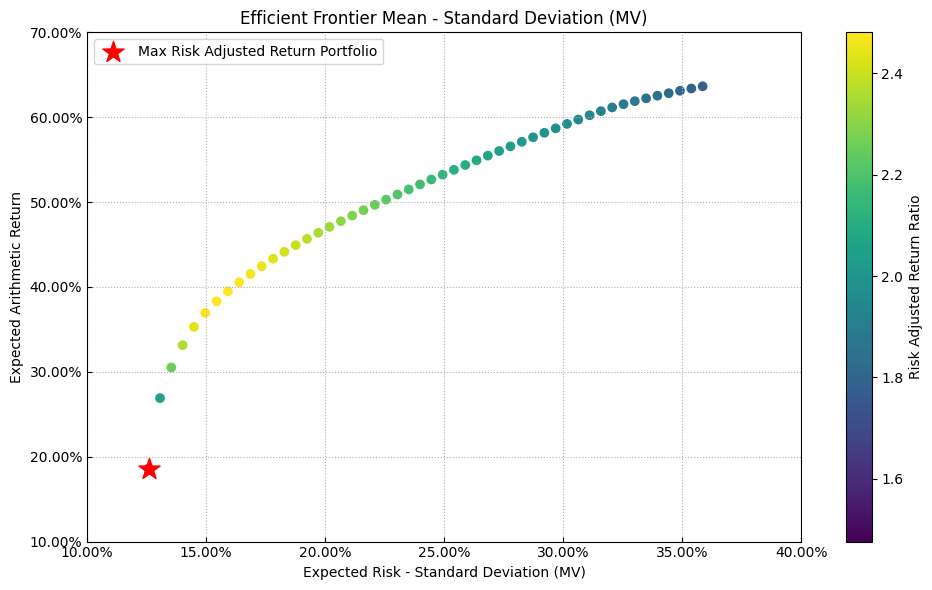

In [8]:
# Plotting frontier

points = 50 # Number of points of the frontier

frontier = port.efficient_frontier(model=model, rm=rm, points=points, rf=rf, hist=hist)
# display(frontier.T.tail())

# Plotting the efficient frontier

label = 'Max Risk Adjusted Return Portfolio' # Title of point
mu = port.mu # Expected returns
cov = port.cov # Covariance matrix
returns = port.returns # Returns of the assets

ax = rp.plot_frontier(w_frontier=frontier, mu=mu, cov=cov, returns=returns, rm=rm,
                      rf=rf, alpha=0.05, cmap='viridis', w=w_min_risk, label=label,
                      marker='*', s=16, c='r', height=6, width=10, ax=None)


In [9]:
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

In [10]:
# Risk Measures available:
#
# 'MV': Standard Deviation.
# 'MAD': Mean Absolute Deviation.
# 'MSV': Semi Standard Deviation.
# 'FLPM': First Lower Partial Moment (Omega Ratio).
# 'SLPM': Second Lower Partial Moment (Sortino Ratio).
# 'CVaR': Conditional Value at Risk.
# 'EVaR': Entropic Value at Risk.
# 'WR': Worst Realization (Minimax)
# 'MDD': Maximum Drawdown of uncompounded cumulative returns (Calmar Ratio).
# 'ADD': Average Drawdown of uncompounded cumulative returns.
# 'CDaR': Conditional Drawdown at Risk of uncompounded cumulative returns.
# 'EDaR': Entropic Drawdown at Risk of uncompounded cumulative returns.
# 'UCI': Ulcer Index of uncompounded cumulative returns.

rms = ['MV', 'MAD', 'MSV', 'FLPM', 'SLPM', 'CVaR',
       'EVaR', 'WR', 'MDD', 'ADD', 'CDaR', 'UCI', 'EDaR']

w_s = pd.DataFrame([])

for i in rms:
    w = port.optimization(model=model, rm=i, obj=obj, rf=rf, l=l, hist=hist)
    w_s = pd.concat([w_s, w], axis=1)
    
w_s.columns = rms

w_s.style.format("{:.2%}").background_gradient(cmap='YlGn')

,MV,MAD,MSV,FLPM,SLPM,CVaR,EVaR,WR,MDD,ADD,CDaR,UCI,EDaR
TIMS3.SA,5.82%,0.42%,3.37%,0.00%,2.74%,4.35%,0.00%,0.00%,11.57%,9.28%,16.36%,14.50%,14.90%
VIVT3.SA,0.00%,0.00%,1.33%,0.00%,0.67%,0.00%,4.86%,5.48%,5.93%,5.43%,5.28%,6.59%,4.85%
SUZB3.SA,0.00%,0.06%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
KLBN11.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
CSAN3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.07%,3.74%,0.00%,4.70%,0.00%,1.99%,0.00%
VBBR3.SA,11.12%,2.26%,16.12%,0.00%,16.61%,8.02%,10.91%,9.00%,0.00%,0.00%,0.00%,0.00%,0.00%
PRIO3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
UGPA3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
ENAT3.SA,0.00%,0.00%,0.00%,0.00%,0.00%,6.69%,13.95%,15.20%,0.00%,0.00%,0.00%,0.00%,0.00%
PETR3.SA,0.00%,0.00%,0.00%,0.00%,2.12%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%,0.00%
